# Imports

In [5]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [6]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.tsa.api as tsa
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
import itertools
from numpy import inf
from sklearn.metrics import mean_squared_error
import gc

sns.set_style('whitegrid')
np.random.seed(4321)

In [7]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, GRU, Input, concatenate, Embedding, Reshape, BatchNormalization, Dropout 
from tensorflow.keras.optimizers import SGD
import TimeSeriesHelpers as tsh

SEED = 4321
np.random.seed(SEED)
tf.random.set_seed(SEED)

#Check GPU
physical_devices = tf.config.list_physical_devices('GPU')
print('TF version:',tf.__version__ ,  tf.test.gpu_device_name() )

#memory control 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

TF version: 2.6.0 /device:GPU:0


## Data

In [4]:
crime_2021 = pd.read_csv('data/crime_2021.csv')
crime_2021 = crime_2021[(crime_2021['OFFENSE_DESCRIPTION']=="VANDALISM") | (crime_2021['OFFENSE_DESCRIPTION']=="VERBAL DISPUTE")]
crime_2021.head()

INCIDENT_NUMBER  OFFENSE_CODE  OFFENSE_CODE_GROUP OFFENSE_DESCRIPTION  \
4        212996778          3301                 NaN      VERBAL DISPUTE   
27       212046473          3301                 NaN      VERBAL DISPUTE   
40       212046455          3301                 NaN      VERBAL DISPUTE   
63       212046420          1402                 NaN           VANDALISM   
81       212046396          3301                 NaN      VERBAL DISPUTE   

   DISTRICT REPORTING_AREA  SHOOTING     OCCURRED_ON_DATE  YEAR  MONTH  \
4        C6            204         0  2021-02-01 06:20:00  2021      2   
27      E18            516         0  2021-07-07 23:53:00  2021      7   
40       C6            207         0  2021-07-07 21:44:00  2021      7   
63       D4            150         0  2021-07-07 02:41:00  2021      7   
81       B2            183         0  2021-07-07 17:38:00  2021      7   

   DAY_OF_WEEK  HOUR  UCR_PART         STREET        Lat       Long  \
4       Monday     6       NaN  GILLETTE PARK  42.344125 -71.056853   
27   Wednesday    23       NaN   NEPONSET AVE  42.296207 -71.054879   
40   Wednesday    21       NaN   SEAPORT BLVD  42.350827 -71.043418   
63   Wednesday     2       NaN    APPLETON ST  42.345394 -71.073802   
81   Wednesday    17       NaN      DUDLEY ST  42.319871 -71.070963   

                                 Location  
4   (42.3441248392933, -71.0568533916328)  
27  (42.2962066695049, -71.0548785223855)  
40  (42.3508268662159, -71.0434175813107)  
63  (42.3453940583975, -71.0738024655648)  
81  (42.3198707618137, -71.0709626304778)

In [5]:
# get a quick overview of the data
crime_2021.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2467 entries, 4 to 34897
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   INCIDENT_NUMBER      2467 non-null   object 
 1   OFFENSE_CODE         2467 non-null   int64  
 2   OFFENSE_CODE_GROUP   0 non-null      float64
 3   OFFENSE_DESCRIPTION  2467 non-null   object 
 4   DISTRICT             2409 non-null   object 
 5   REPORTING_AREA       2467 non-null   object 
 6   SHOOTING             2467 non-null   int64  
 7   OCCURRED_ON_DATE     2467 non-null   object 
 8   YEAR                 2467 non-null   int64  
 9   MONTH                2467 non-null   int64  
 10  DAY_OF_WEEK          2467 non-null   object 
 11  HOUR                 2467 non-null   int64  
 12  UCR_PART             0 non-null      float64
 13  STREET               2443 non-null   object 
 14  Lat                  2467 non-null   float64
 15  Long                 2467 non-null   

## Data Exploration and Manipulation


### Convert OCCURRED_ON_DATE to datetime, sort data, and change the  index to datetime
> OCCURRED_ON_DATE is currently an object therefore it must be converted to datetime and sorted. 

In [6]:
crime_2021['OCCURRED_ON_DATE'] = pd.to_datetime(crime_2021['OCCURRED_ON_DATE'])                      #Convert to datetime
crime_2021.sort_values(by=['OCCURRED_ON_DATE'], inplace=True, ascending=True, ignore_index = True)   #sort by date
crime_2021.index = crime_2021['OCCURRED_ON_DATE']                                                    #change index to datetime
crime_2021.tail()

INCIDENT_NUMBER  OFFENSE_CODE  OFFENSE_CODE_GROUP  \
OCCURRED_ON_DATE                                                        
2021-07-07 12:03:00       212046300          1402                 NaN   
2021-07-07 16:15:00       212046373          3301                 NaN   
2021-07-07 17:38:00       212046396          3301                 NaN   
2021-07-07 21:44:00       212046455          3301                 NaN   
2021-07-07 23:53:00       212046473          3301                 NaN   

                    OFFENSE_DESCRIPTION DISTRICT REPORTING_AREA  SHOOTING  \
OCCURRED_ON_DATE                                                            
2021-07-07 12:03:00           VANDALISM       B3            426         0   
2021-07-07 16:15:00      VERBAL DISPUTE       E5            691         0   
2021-07-07 17:38:00      VERBAL DISPUTE       B2            183         0   
2021-07-07 21:44:00      VERBAL DISPUTE       C6            207         0   
2021-07-07 23:53:00      VERBAL DISPUTE      E18            516         0   

                       OCCURRED_ON_DATE  YEAR  MONTH DAY_OF_WEEK  HOUR  \
OCCURRED_ON_DATE                                                         
2021-07-07 12:03:00 2021-07-07 12:03:00  2021      7   Wednesday    12   
2021-07-07 16:15:00 2021-07-07 16:15:00  2021      7   Wednesday    16   
2021-07-07 17:38:00 2021-07-07 17:38:00  2021      7   Wednesday    17   
2021-07-07 21:44:00 2021-07-07 21:44:00  2021      7   Wednesday    21   
2021-07-07 23:53:00 2021-07-07 23:53:00  2021      7   Wednesday    23   

                     UCR_PART         STREET        Lat       Long  \
OCCURRED_ON_DATE                                                     
2021-07-07 12:03:00       NaN  BLUE HILL AVE  42.269859 -71.093464   
2021-07-07 16:15:00       NaN      CENTRE ST  42.287094 -71.148221   
2021-07-07 17:38:00       NaN      DUDLEY ST  42.319871 -71.070963   
2021-07-07 21:44:00       NaN   SEAPORT BLVD  42.350827 -71.043418   
2021-07-07 23:53:00       NaN   NEPONSET AVE  42.296207 -71.054879   

                                                  Location  
OCCURRED_ON_DATE                                            
2021-07-07 12:03:00  (42.2698591613484, -71.0934635332552)  
2021-07-07 16:15:00  (42.2870935525911, -71.1482212837716)  
2021-07-07 17:38:00  (42.3198707618137, -71.0709626304778)  
2021-07-07 21:44:00  (42.3508268662159, -71.0434175813107)  
2021-07-07 23:53:00  (42.2962066695049, -71.0548785223855)

In [7]:
#check the unique counts by column

tsh.print_unique(crime_2021)

INCIDENT_NUMBER     	2467
OFFENSE_CODE        	   2
OFFENSE_CODE_GROUP  	   1
OFFENSE_DESCRIPTION 	   2
DISTRICT            	  14
REPORTING_AREA      	 612
SHOOTING            	   2
OCCURRED_ON_DATE    	2414
YEAR                	   1
MONTH               	   7
DAY_OF_WEEK         	   7
HOUR                	  24
UCR_PART            	   1
STREET              	1012
Lat                 	1572
Long                	1572
Location            	1572


In [8]:
#A closer look at SHOOTING because it only has two unique values

crime_2021['SHOOTING'].value_counts()

0    2422
1      45
Name: SHOOTING, dtype: int64

### Drop Unused Columns
> - The problem statement asks for the number of incidents, not the location, so all location data will be dropped.
> - SHOOTING is too sparse to add any value to this particular task.
> - UCR_PART and OFFENSE_CODE_GROUP only contain a single value.
> - Other time columns do not contain any additional information.
#### This becomes a univariate time series.

In [9]:
cols_to_drop = ['INCIDENT_NUMBER', 'OFFENSE_CODE_GROUP','OFFENSE_DESCRIPTION', 'DISTRICT', 'REPORTING_AREA', \
                'SHOOTING', 'OCCURRED_ON_DATE', 'YEAR', 'MONTH', 'DAY_OF_WEEK', 'HOUR', 'UCR_PART', 'STREET', \
                'Lat', 'Long', 'Location']

crime_2021.drop(cols_to_drop, axis = 1, inplace = True)
crime_2021.head(3)

OFFENSE_CODE
OCCURRED_ON_DATE                 
2021-01-01 00:00:00          1402
2021-01-01 00:00:00          1402
2021-01-01 03:25:00          1402

### Split Data and Resample to Daily
> Split the data by offense code and resample the data to daily count

In [10]:
crime_2021_VANDALISM = crime_2021[crime_2021['OFFENSE_CODE'] == 1402]
crime_2021_VERBAL = crime_2021[crime_2021['OFFENSE_CODE'] == 3301]

crime_2021_VANDALISM = crime_2021_VANDALISM.resample('d').count()
crime_2021_VERBAL = crime_2021_VERBAL.resample('d').count()

crime_2021_VANDALISM.head()

OFFENSE_CODE
OCCURRED_ON_DATE              
2021-01-01                   9
2021-01-02                  11
2021-01-03                   6
2021-01-04                   3
2021-01-05                   5

In [11]:
crime_2021_VERBAL.head()

OFFENSE_CODE
OCCURRED_ON_DATE              
2021-01-01                   4
2021-01-02                   2
2021-01-03                   5
2021-01-04                   3
2021-01-05                   4

In [12]:
#Rename columns and concatenate

crime_2021_VANDALISM.rename(columns = {'OFFENSE_CODE':'VANDALISM'}, inplace = True)
crime_2021_VERBAL.rename(columns = {'OFFENSE_CODE':'VERBAL_DISPUTE'}, inplace = True)

crime_2021_clean = pd.concat([crime_2021_VANDALISM, crime_2021_VERBAL], axis = 1)
crime_2021_clean.tail()

VANDALISM  VERBAL_DISPUTE
OCCURRED_ON_DATE                           
2021-07-03               10               2
2021-07-04               13               3
2021-07-05               15               9
2021-07-06                5               5
2021-07-07                4               5

### EDA

#### The data appears to be stationary with a seasonal pattern, possibly weekly and/or monthly. It is not clear if there is a linear trend.

In [13]:
fig = px.line(crime_2021_clean, x=crime_2021_clean.index, y=['VANDALISM', 'VERBAL_DISPUTE'])

fig.show()

#### The data appears to be comprised of trend, seasonal, and residuals.
#### I will use Satsmodels tsa to decompose the data and verify my theory.

vandalism_components = tsa.seasonal_decompose(crime_2021_clean['VANDALISM'], model='additive')
verbal_components = tsa.seasonal_decompose(crime_2021_clean['VERBAL_DISPUTE'], model='additive')

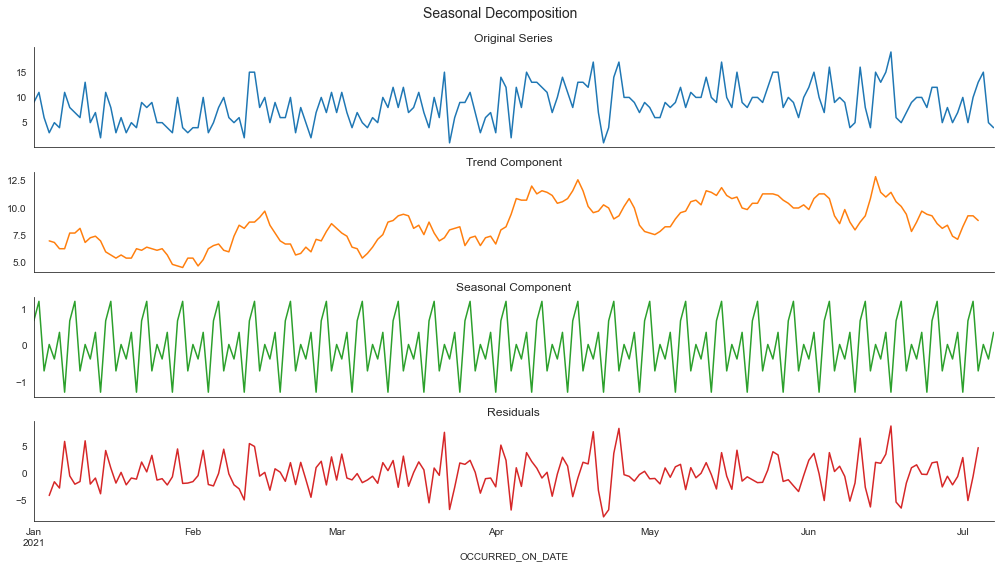

In [14]:
#Check VANDALISM

tsh.plot_decomposition(crime_2021_clean['VANDALISM'])

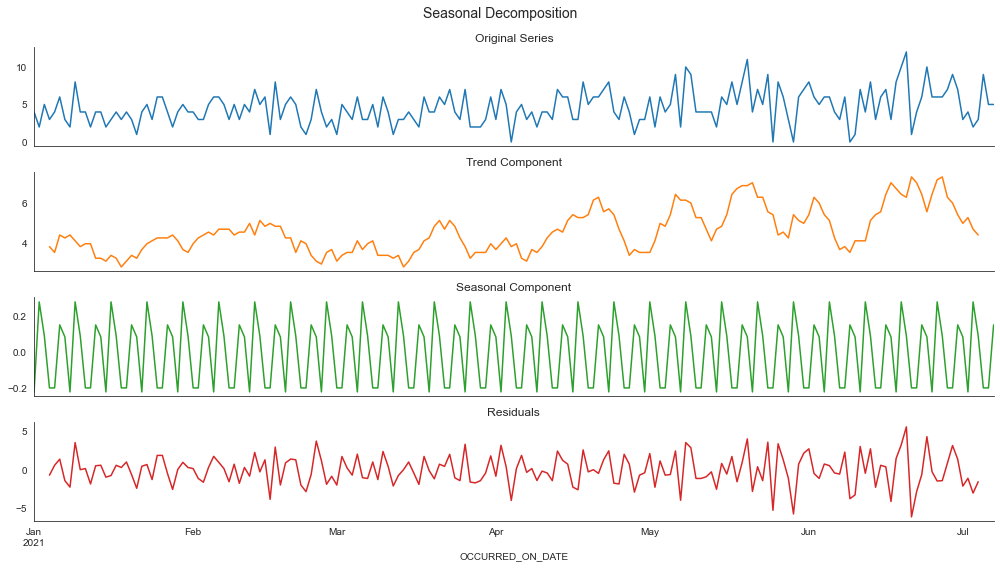

In [15]:
#Check VERBAL_DISPUTE

tsh.plot_decomposition(crime_2021_clean['VERBAL_DISPUTE'])

### Check the Correlation 
> VANDALISM and VERBAL_DISPUTE have low correlation so two seperate models will be used.

In [16]:
crime_2021_clean.corr()

VANDALISM  VERBAL_DISPUTE
VANDALISM        1.000000        0.089148
VERBAL_DISPUTE   0.089148        1.000000

### Dickey-Fuller Test for Stationarity
> This test will determine if further data manipulation steps are necessary

In [17]:
tsh.dickey_fuller(crime_2021_clean['VANDALISM'])

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [18]:
tsh.dickey_fuller(crime_2021_clean['VERBAL_DISPUTE'])

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

### Check autocorrelation to determine seasonality

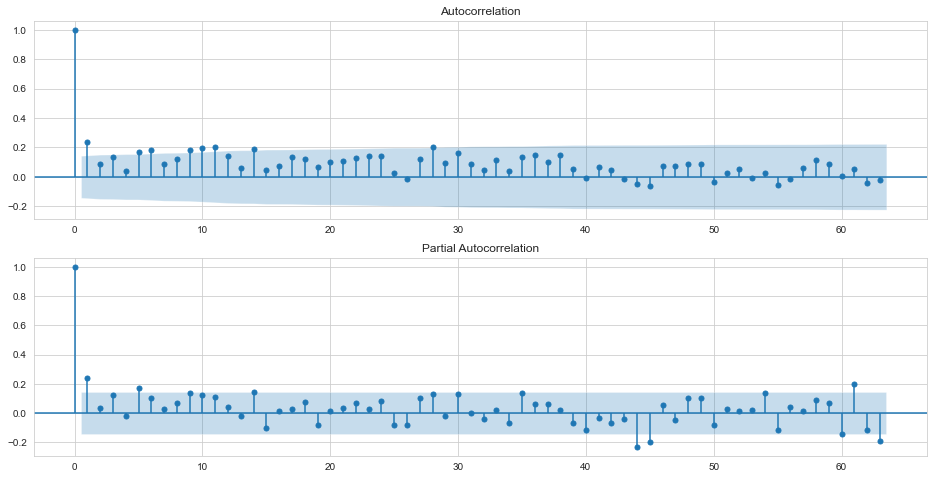

In [23]:
#VANDALISM

fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(crime_2021_clean['VANDALISM'],lags=63,ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(crime_2021_clean['VANDALISM'],lags=63,ax=ax2)

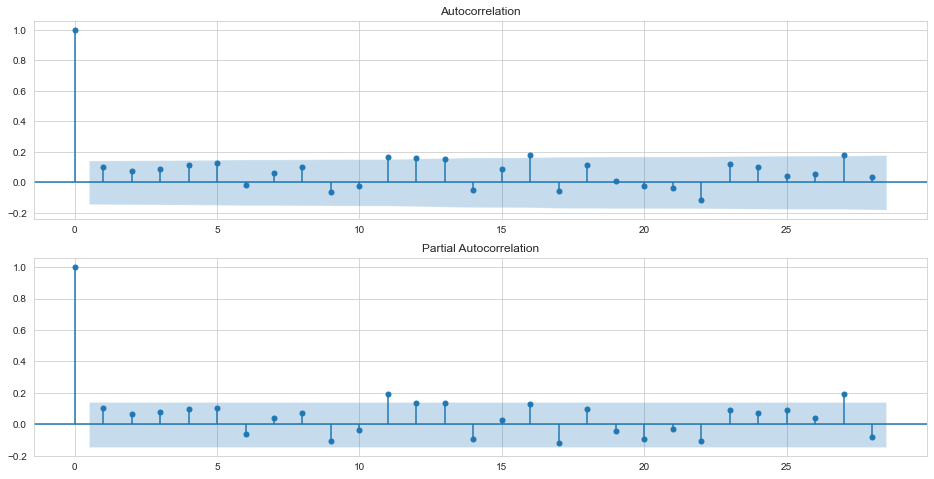

In [24]:
#VERBAL_DISPUTE

fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(crime_2021_clean['VERBAL_DISPUTE'],lags=28,ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(crime_2021_clean['VERBAL_DISPUTE'],lags=28,ax=ax2)

### Log Transformation
>Transform the data for use in a SARIMA model

In [25]:
vandalism_log = np.log(crime_2021_clean['VANDALISM'])
verbal_log = np.log(crime_2021_clean['VERBAL_DISPUTE'])
verbal_log[verbal_log == -inf]=0    #some values were zero before log

## Model
> SARIMAX
>
>The seasonality of the data and the long prediction window led me to choose a SARIMA model, specifically Statsmodels' SARIMAX

### Find the parameters of the SARIMAX Model
> A grid search is used to determine the ideal parameters of the model. This is very time consuming and often yields mediocre results, but a good starting point

### Parameter Grid Search

In [26]:
#Vandalism Grid Search

vandalism_params_aic, vandalism_params_bic = tsh.sarimax_grid_search(vandalism_log, max_iter = 300, n_season = 14)
print(vandalism_params_aic)
print(vandalism_params_bic)

           pdq           pdqs         aic         bic
380  (1, 1, 2)  (0, 0, 2, 14)  274.261142  293.647793
           pdq           pdqs         aic         bic
108  (0, 1, 1)  (0, 0, 0, 14)  278.091501  284.553718


In [25]:
#Verbal Dispute Grid Search

verbal_params_aic, verbal_params_bic = tsh.sarimax_grid_search(verbal_log, max_iter = 300, n_season = 14)
print(verbal_params_aic)
print(verbal_params_bic)

           pdq           pdqs         aic         bic
109  (0, 1, 1)  (0, 0, 1, 14)  312.414834  322.108159
           pdq           pdqs         aic         bic
108  (0, 1, 1)  (0, 0, 0, 14)  313.606048  320.068265


### Final Models

In [26]:
# Final Vandalism Model

#order = (1,1,2)
order = (1,1,2)
#seasonal_order = (0,0,2,14)
seasonal_order = (0,1,0,56)

vandalism_model = tsa.statespace.SARIMAX(vandalism_log, order = order, seasonal_order = seasonal_order).fit(maxiter= 300)
vandalism_model.summary(alpha=.05)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                           VANDALISM   No. Observations:                  188
Model:             SARIMAX(1, 1, 2)x(0, 1, [], 56)   Log Likelihood                -146.933
Date:                             Sat, 21 Aug 2021   AIC                            301.866
Time:                                     04:58:38   BIC                            313.367
Sample:                                 01-01-2021   HQIC                           306.539
                                      - 07-07-2021                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5027      0.464     -1.084      0.278      -1.412       0.406
ma.L1         -0.3443      0.416     -0.827      0.408      -1.160       0.471
ma.L2         -0.6136      0.396     -1.548      0.122      -1.391       0.163
sigma2         0.5399      0.053     10.156      0.000       0.436       0.644
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):                26.21
Prob(Q):                              0.71   Prob(JB):                         0.00
Heteroskedasticity (H):               0.93   Skew:                             0.24
Prob(H) (two-sided):                  0.82   Kurtosis:                         5.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

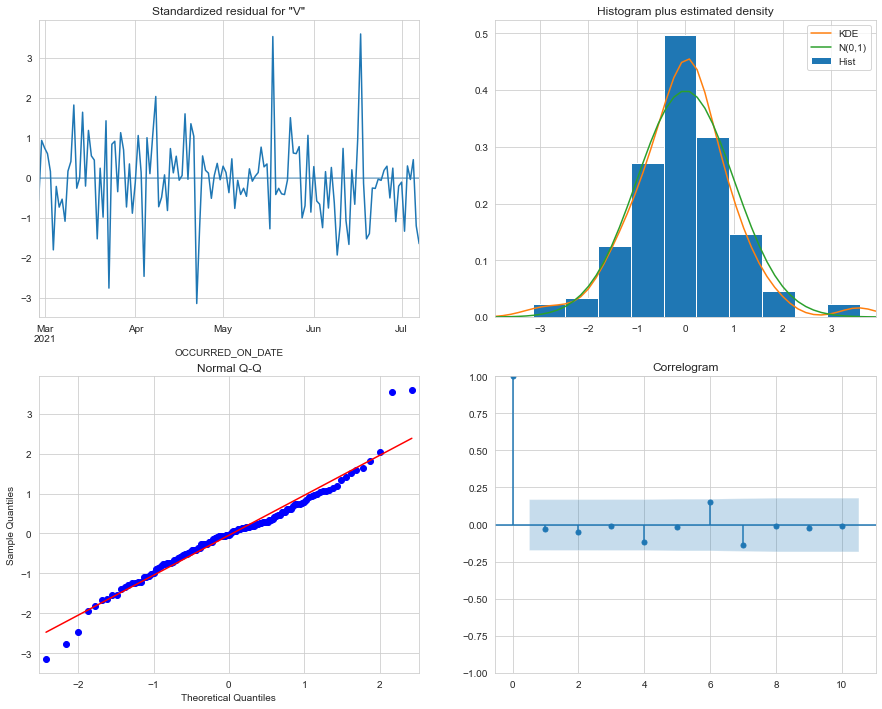

In [27]:
vandalism_model.plot_diagnostics(figsize=(15, 12))
plt.show()

In [28]:
# Final Verbal Dispute Model

# order = (0,1,1)
# seasonal_order = (0,0,1,14)
order = (1,1,3)
seasonal_order = (2,1,0,35)

verbal_model = tsa.statespace.SARIMAX(verbal_log, order = order, seasonal_order = seasonal_order).fit()
verbal_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                      VERBAL_DISPUTE   No. Observations:                  188
Model:             SARIMAX(1, 1, 3)x(2, 1, [], 35)   Log Likelihood                -159.446
Date:                             Sat, 21 Aug 2021   AIC                            332.891
Time:                                     04:58:53   BIC                            354.058
Sample:                                 01-01-2021   HQIC                           341.490
                                      - 07-07-2021                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9297      0.063    -14.832      0.000      -1.053      -0.807
ma.L1         -0.0344   4.56e+04  -7.56e-07      1.000   -8.93e+04    8.93e+04
ma.L2         -0.9999    4.4e+04  -2.27e-05      1.000   -8.62e+04    8.62e+04
ma.L3          0.0343   1564.693   2.19e-05      1.000   -3066.707    3066.776
ar.S.L35      -0.6417      0.102     -6.281      0.000      -0.842      -0.441
ar.S.L70      -0.2323      0.116     -2.003      0.045      -0.460      -0.005
sigma2         0.4129   1.88e+04   2.19e-05      1.000   -3.69e+04    3.69e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                10.32
Prob(Q):                              0.95   Prob(JB):                         0.01
Heteroskedasticity (H):               1.32   Skew:                            -0.55
Prob(H) (two-sided):                  0.32   Kurtosis:                         3.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

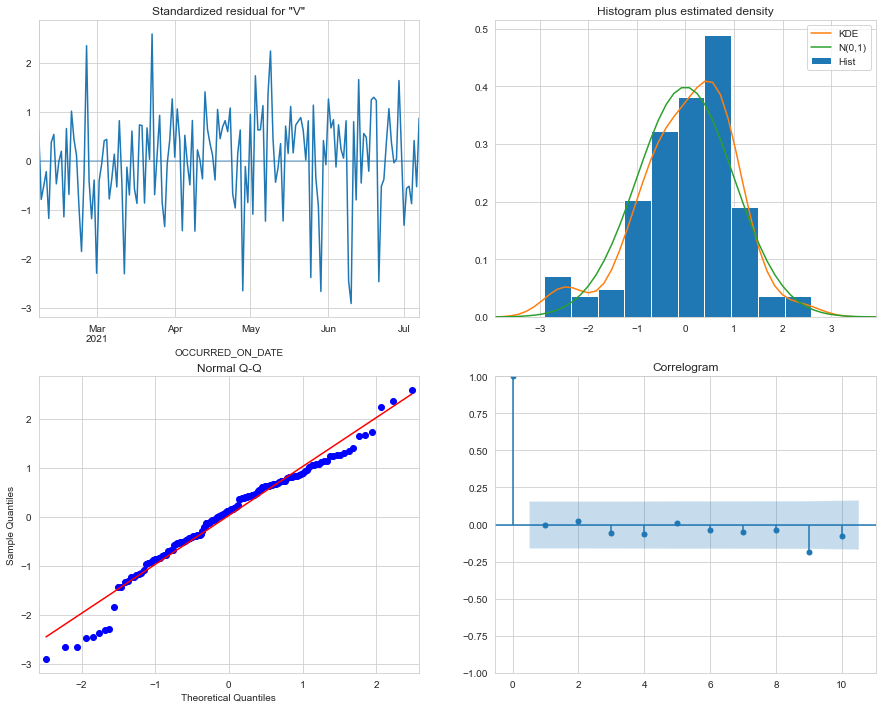

In [29]:
verbal_model.plot_diagnostics(figsize=(15, 12))
plt.show()

## Predictions

In [30]:
#Predictions

vandalism_preds = np.exp(vandalism_model.predict(start = '2021-07-09', end = '2021-12-31', dynamic = True))
verbal_preds = np.exp(verbal_model.predict(start = '2021-07-09', end = '2021-12-31', dynamic = True))

In [31]:
#crime_pred.csv

crime_pred = pd.DataFrame(vandalism_preds)
crime_pred.rename(columns = {'predicted_mean':'VANDALISM'}, inplace = True)
crime_pred['VERBAL DISPUTE']= verbal_preds

#crime_pred.to_csv('crime_pred.csv', index=True)

## Visualization of Predictions
>After some manual tuning the final predictions look reasonable

In [32]:
crime_names = crime_2021_clean.rename(columns = {'VANDALISM':'Vandalism', 'VERBAL_DISPUTE':'Verbal_Dispute'})
preds_wdata = pd.concat([crime_names, crime_pred], axis = 1)
preds_wdata.rename(columns = {'Vandalism':'Vandalism', 'Verbal_Dispute':'Verbal_Dispute',
                              'VANDALISM':'Vandalism_Preds', 'VERBAL DISPUTE':'Verbal_Preds'}, inplace = True)

<AxesSubplot:>

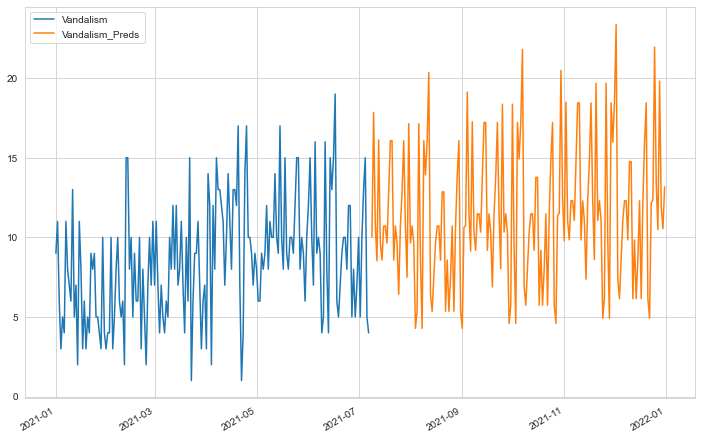

In [33]:
preds_wdata[['Vandalism', 'Vandalism_Preds']].plot(figsize = (12,8))

<AxesSubplot:>

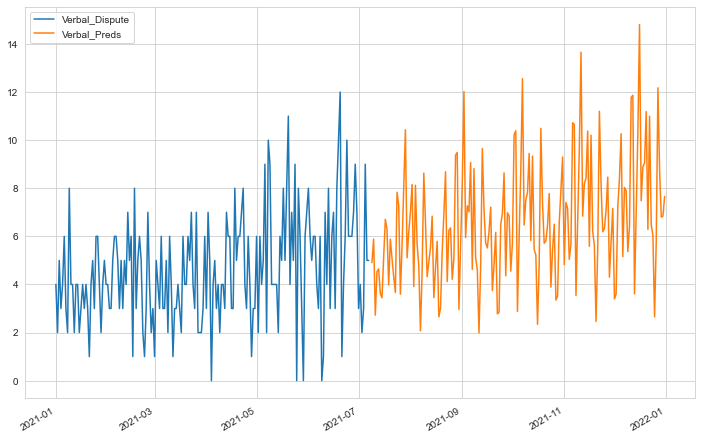

In [34]:
preds_wdata[['Verbal_Dispute', 'Verbal_Preds']].plot(figsize = (12,8))